In [1]:
from datetime import datetime

from loguru import logger
from meteostat import Daily, Point
import pandas as pd

from forecasting import config
from forecasting.modeling.evaluation import evaluate_forecast, log_to_mlflow
from forecasting.modeling.predict import (
    holt_trend_forecast,
    holt_winters_forecast,
    moving_average_forecast,
    naive_forecast,
    ses_forecast,
)
from forecasting.modeling.tuning import bayesian_tune
from forecasting.plots import plot_forecast_with_train, plot_forecasts, plot_time_series
from forecasting.validation import (
    check_column_no_nan,
    check_column_numeric,
    check_index_no_duplicates,
    check_index_no_missing,
    check_index_regular_frequency,
    check_index_type,
)

2025-08-07 14:10:31.506 | INFO     | forecasting.config:<module>:17 - PROJ_ROOT path is: /home/vergabyte/meteo_forecast


In [2]:
# Set time period
start = datetime(2020, 1, 1)
end = datetime(2022, 12, 31)

# Create Point for Athens, GR
athens = Point(37.98, 23.73)

# Get daily data for 2020-2022
data = Daily(athens, start, end)
df = data.fetch()

In [3]:
print(df.shape)
print(df.head())

(1096, 10)
            tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt    pres  tsun
time                                                                    
2020-01-01   8.4   3.5  11.8   0.0  <NA>  <NA>   7.2  <NA>  1022.5  <NA>
2020-01-02   7.1   3.7   8.7   1.5  <NA>  <NA>  16.7  <NA>  1024.7  <NA>
2020-01-03   8.9   6.8  11.2   3.3  <NA>  <NA>  11.7  <NA>  1023.2  <NA>
2020-01-04  10.0   6.5  14.4  <NA>  <NA>  <NA>   2.5  <NA>  1019.1  <NA>
2020-01-05   9.6   6.8  13.1   0.0  <NA>  <NA>   8.7  <NA>  1011.6  <NA>


In [4]:
print(df.index.min())
print(df.index.max())

2020-01-01 00:00:00
2022-12-31 00:00:00


In [5]:
check_column_no_nan(df, "tavg")
check_column_numeric(df, "tavg")

2025-08-07 14:10:32.469 | INFO     | forecasting.validation:check_column_no_nan:9 - tavg has no NaN
2025-08-07 14:10:32.470 | INFO     | forecasting.validation:check_column_numeric:15 - tavg is numeric


In [6]:
check_index_type(df)
check_index_no_missing(df)
check_index_no_duplicates(df)
check_index_regular_frequency(df)

2025-08-07 14:10:32.492 | INFO     | forecasting.validation:check_index_type:21 - Index is DatetimeIndex
2025-08-07 14:10:32.493 | INFO     | forecasting.validation:check_index_no_missing:27 - Index has no missing values
2025-08-07 14:10:32.494 | INFO     | forecasting.validation:check_index_no_duplicates:33 - Index has no duplicates
2025-08-07 14:10:32.494 | INFO     | forecasting.validation:check_index_regular_frequency:40 - Index frequency: D


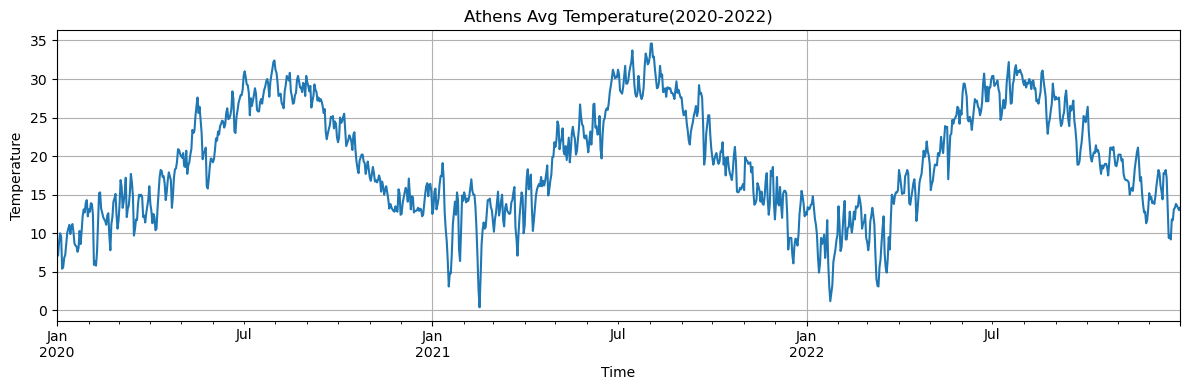

In [7]:
plot_time_series(data=df["tavg"], title="Athens Avg Temperature(2020-2022)", ylabel="Temperature")

In [8]:
series = df["tavg"]

train_start = pd.Timestamp("2020-01-01")
train_end = pd.Timestamp("2021-12-31")

test_start = pd.Timestamp("2022-01-01")
test_end = pd.Timestamp("2022-12-31")

y_train = series.loc[train_start:train_end]
y_test = series.loc[test_start:test_end]

forecast_horizon = len(y_test)

In [9]:
y_pred_naive = naive_forecast(y_train, forecast_horizon)
y_pred_ma = moving_average_forecast(y_train, forecast_horizon, window_size=30)
y_pred_ses = ses_forecast(y_train, forecast_horizon, alpha=0.4)

2025-08-07 14:10:32.775 | INFO     | __main__:<module>:10 - [Naive] Evaluation metrics: {'mae': 7.995616438356165, 'mape': 0.45110422830316754, 'rmse': 9.773635209351712}
2025-08-07 14:10:32.786 | INFO     | __main__:<module>:10 - [Moving Avg] Evaluation metrics: {'mae': 8.345397260273971, 'mape': 0.45841286948045173, 'rmse': 10.159315112823494}
2025-08-07 14:10:32.796 | INFO     | __main__:<module>:10 - [SES] Evaluation metrics: {'mae': 7.824213506521537, 'mape': 0.44806794624239593, 'rmse': 9.58153744565402}


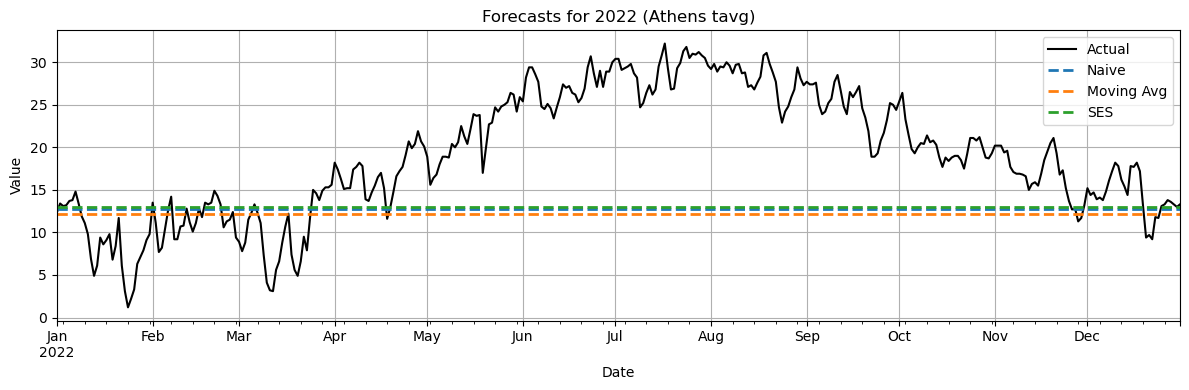

In [10]:
forecasts = {
    "Naive": y_pred_naive,
    "Moving Avg": y_pred_ma,
    "SES": y_pred_ses,
}

for name, y_pred in forecasts.items():
    metrics = evaluate_forecast(y_test, y_pred, method_name=name)
    log_to_mlflow(method_name=name, metrics=metrics)
    logger.info(f"[{name}] Evaluation metrics: {metrics}")

plot_forecasts(y_test, forecasts, title="Forecasts for 2022 (Athens tavg)")

2025-08-07 14:10:32.964 | INFO     | __main__:<module>:9 - Holt Trend Evaluation metrics: {'mae': 5.822919880757111, 'mape': 0.395100038229322, 'rmse': 7.115295143567979}


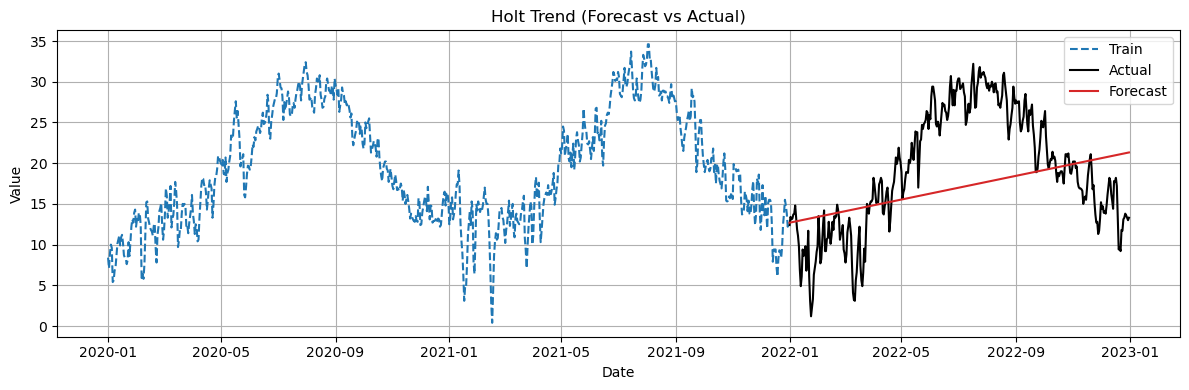

In [11]:
y_pred_holt = holt_trend_forecast(
    y=y_train, forecast_horizon=forecast_horizon, alpha=0.9, beta=0.2
)

metrics = evaluate_forecast(y_test, y_pred_holt)

log_to_mlflow(method_name="Holt", metrics=metrics)

logger.info(f"Holt Trend Evaluation metrics: {metrics}")

plot_forecast_with_train(y_train, y_test, y_pred_holt, title="Holt Trend (Forecast vs Actual)")

In [12]:
params, forecast, result = bayesian_tune(y_train, y_test)
metrics = evaluate_forecast(y_test, forecast)

log_to_mlflow(method_name="Holt-Winters Tuning (Bayesian)", metrics=metrics, params=params)

logger.info(f"Best params: { {k: round(v, 1) for k, v in params.items()} }")

2025-08-07 14:10:40.703 | INFO     | __main__:<module>:6 - Best params: {'alpha': 0.4, 'beta': 0.0, 'gamma': 0.3}


2025-08-07 14:10:40.781 | INFO     | __main__:<module>:14 - [Holt-Winters (Manual)] Evaluation metrics: {'mae': 2.7930766542256555, 'mape': 0.2435458362355483, 'rmse': 3.632324394694485}


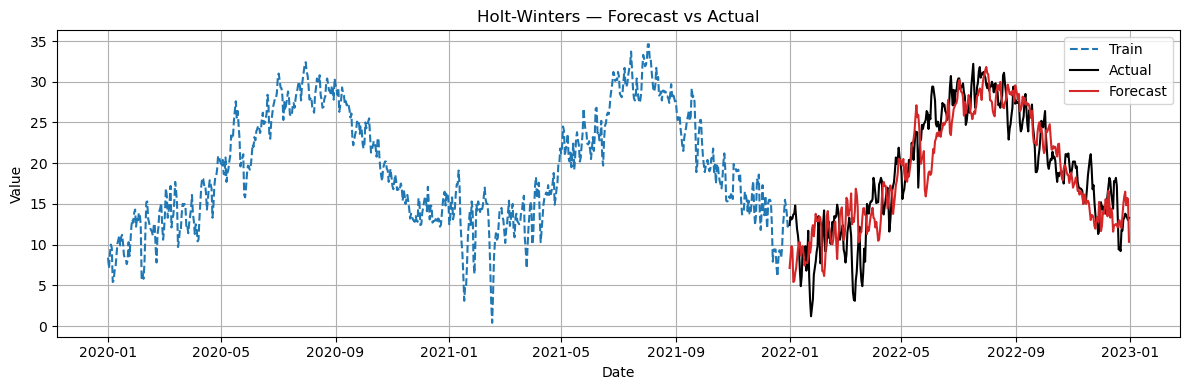

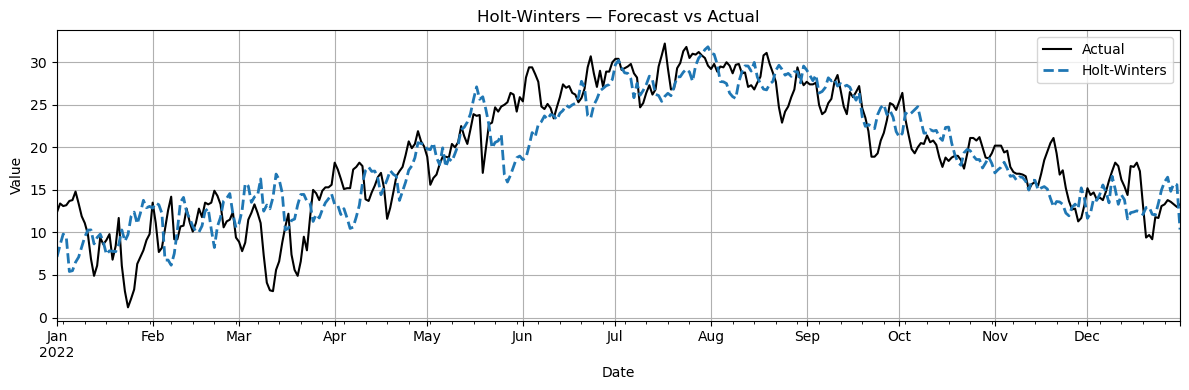

In [13]:
y_pred_holt_winters = holt_winters_forecast(
    y=y_train,
    forecast_horizon=forecast_horizon,
    alpha=0.4,
    beta=0.0,
    gamma=0.3,
    seasonal_periods=365,
)

metrics = evaluate_forecast(y_test, y_pred_holt_winters)

log_to_mlflow(method_name="Holt-Winters", metrics=metrics, params=params)

logger.info(f"[Holt-Winters (Manual)] Evaluation metrics: {metrics}")

plot_forecast_with_train(
    y_train, y_test, y_pred_holt_winters, title="Holt-Winters — Forecast vs Actual"
)

plot_forecasts(
    y_true=y_test,
    forecasts={"Holt-Winters": y_pred_holt_winters},
    title="Holt-Winters — Forecast vs Actual",
)